# Модель для бинарной классификации наличия диабета

## Описание датасета

Данные взяты с https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

Файл _diabetes_prediction_dataset.csv_ содержит медицинские и демографические данные пациентов, а также их диабетический статус, положительный или отрицательный. 

Он состоит из различных характеристик, таких как возраст, пол, индекс массы тела (ИМТ), гипертония, болезни сердца, история курения, уровень HbA1c и уровень глюкозы в крови. 

Датасет содержит 100 000 записей и 9 полей с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from tqdm.auto import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score, \
    confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score

tqdm.pandas()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})
pd.set_option('mode.chained_assignment', None)

/home/tolya/work/python/project/venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def df_overview(df, ascateg=[], cols=2, size=(12, 12)):
    """ Функция выводит обзорные графики колонок датасета в виде сетки с кол-вом колонок cols """
  
    n = len(df.columns)
    
    if n % cols == 0:
        rows = n // cols
    else:
        rows = n // cols + 1
    
    fig, axs = plt.subplots(rows, cols, figsize=size)
   
    # скроем все сетки
    for ax in axs.ravel():
        ax.axison = False
        
    for feat, ax in tqdm(zip(df.columns, axs.ravel())):
      
        ax.axison = True
        if df[feat].dtype == 'object' or feat in ascateg:
            sns.countplot(data=df, x=feat, ax=ax)
        else:
            # sns.jointplot(data=DF, x=feature, y='Exited', kind="reg", truncate=False)
            sns.histplot(data=df, x=feat, kde=True, ax=ax)
        ax.set_xlabel(feat, fontsize=10)
        ax.set_ylabel("Count", fontsize=9)
        ax.tick_params(labelsize=6)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()
    
def df_overview_boxplot(df, cols=2, size=(12, 12)):
    """ Функция выводит бокс-плоты для всех числовых колонок датасета в виде сетки с кол-вом колонок cols """
  
    num_columns = list(df.dtypes[df.dtypes != 'object'].index)
    n = len(num_columns)
    
    if n % cols == 0:
        rows = n // cols
    else:
        rows = n // cols + 1
    
    fig, axs = plt.subplots(rows, cols, figsize=size)
   
    # скроем все сетки
    for ax in axs.ravel():
        ax.axison = False
        
    for feat, ax in tqdm(zip(num_columns, axs.ravel())):
      
        ax.axison = True
        sns.boxplot(data=df, x=feat, dodge=True, ax=ax)
        # sns.histplot(data=df, x=feat, kde=True, ax=ax)
        ax.set_xlabel(feat, fontsize=10)
        # ax.set_ylabel("Count", fontsize=9)
        ax.tick_params(labelsize=6)

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()


In [3]:
def metric_calculation(y_test: np.ndarray, y_predict: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    print(f'Metrics:')
    
    acc = accuracy_score(y_test, y_predict)
    print(f"Accuracy: {acc}") 
    
    f1 = f1_score(y_test, y_predict)
    print(f"F1: {f1}") 
    
    roc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {roc}") 
    
    rec = recall_score(y_test, y_predict)
    print(f"Recall: {rec}") 
    
    prc = precision_score(y_test, y_predict)
    print(f"Precision: {prc}") 
    
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    return {"accuracy": acc, "f1 score": f1, "roc-auc score": roc, "recal score": rec, "precision score": prc, "conf_matrix": cm}

In [4]:
def plot_precision_recall_curve(y_true, y_pred_score, beta=1):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_score)
    fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    
    if np.isnan(fscore).any():
        fscore = np.nan_to_num(fscore, nan=0.0)
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
        
    print(f"Best Threshold={thresholds[ix]} (idx={ix})", 
        f"F-Score={fscore[ix]:.03f}",
        f"Beta={beta}", 
        f"Precision={precision[ix]:.03f}", 
        f"Recall={recall[ix]:.03f}")

    plt.figure(figsize=(9, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=plt.gca())
    
    plt.axvline(recall[ix], color="red", alpha=1, ls="--", 
                label=f"Recall={recall[ix]:.03f}")
    
    plt.axhline(precision[ix], color="red", alpha=1, ls="-.",
                label=f"Precision={precision[ix]:.03f}")
    plt.title(f"Precision-recall кривая (Max F-score: {fscore[ix]:.03f} beta={beta})")
    plt.legend()
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return precision, recall, thresholds, fscore, ix

def plot_roc_auc_curve(y_true, y_pred_score):
    score = roc_auc_score(y_true, y_pred_score)
    print(f"ROC-AUC score: {score:.03f}")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    plt.figure(figsize=(9, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca())
    plt.title(f"ROC-AUC кривая (Score: {score:.03f})")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return score
    
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    plt.figure(figsize=(9, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=plt.gca(), cmap='cividis')
    plt.title("Матрица ошибок")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return cm

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def get_feature_names_out(self, feature_names_out):
        if feature_names_out:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def get_feature_names_out(self, feature_names_out):
        return self.columns
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, dtype=np.int8)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

## Загрузка данных

In [6]:
DF = pd.read_csv("./diabetes_prediction_dataset.csv", delimiter=",")
DF

gender   age  hypertension  heart_disease smoking_history    bmi   
0      Female  80.0             0              1           never  25.19  \
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140         0  
1              6.6                   80         0  
2              5.7                  158         0  
3              5.0                  155         0  
4              4.8                  155         0  
...            ...                  ...       ...  
99995          6.2                   90         0  
99996          6.5                  100         0  
99997          5.7                  155         0  
99998          4.0                  100         0  
99999          6.6                   90         0  

[100000 rows x 9 columns]

## EDA

In [7]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


0it [00:00, ?it/s]

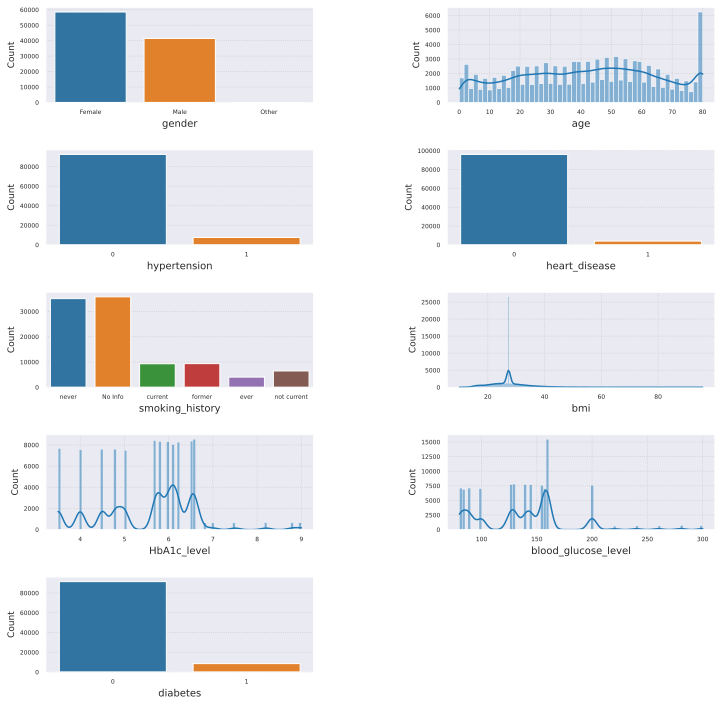

In [8]:
df_overview(DF, ascateg=['heart_disease', 'hypertension', 'diabetes'])

### Gender

In [9]:
# значения поля
DF.gender.value_counts(dropna=False)

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [10]:
# посмотрим на записи с этим значением
DF[DF.gender == 'Other']

gender   age  hypertension  heart_disease smoking_history    bmi   
12669  Other  10.0             0              0     not current  14.09  \
14838  Other  19.0             0              0         No Info  27.32   
16702  Other  39.0             0              0     not current  31.24   
18691  Other  10.0             0              0     not current  16.59   
23266  Other  23.0             0              0         No Info  24.23   
31985  Other  53.0             0              0         No Info  27.32   
33805  Other  45.0             0              0           never  27.32   
34929  Other  47.0             0              0           never  36.76   
35006  Other  47.0             0              0           never  36.76   
40337  Other  18.0             0              0     not current  30.19   
56238  Other  10.0             0              0     not current  19.75   
66595  Other  55.0             0              0         No Info  27.32   
66887  Other  19.0             0              0         No Info  27.32   
67204  Other   7.0             0              0         No Info  27.32   
68484  Other  52.0             0              0     not current  31.63   
71139  Other  28.0             0              0            ever  27.32   
75302  Other  26.0             0              0     not current  37.49   
75734  Other  24.0             0              0     not current  22.86   

       HbA1c_level  blood_glucose_level  diabetes  
12669          5.0                  140         0  
14838          5.7                  158         0  
16702          6.2                   85         0  
18691          6.1                  160         0  
23266          6.1                  140         0  
31985          6.6                  160         0  
33805          4.0                  159         0  
34929          6.6                   90         0  
35006          3.5                  200         0  
40337          6.1                   90         0  
56238          6.1                  126         0  
66595          5.0                  158         0  
66887          3.5                  160         0  
67204          3.5                  159         0  
68484          6.6                  159         0  
71139          4.5                  126         0  
75302          6.0                   80         0  
75734          6.2                  160         0

In [11]:
# будем считать значение 'Other' ошибкой и удалим строки их содержащие
DF = DF[DF.gender != 'Other']
DF.gender.value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [12]:
# закодируем значения поля при помощи словаря
gender_codes = {'Male': 0, 'Female': 1}
DF['gender'].replace(gender_codes, inplace=True)
DF

gender   age  hypertension  heart_disease smoking_history    bmi   
0           1  80.0             0              1           never  25.19  \
1           1  54.0             0              0         No Info  27.32   
2           0  28.0             0              0           never  27.32   
3           1  36.0             0              0         current  23.45   
4           0  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995       1  80.0             0              0         No Info  27.32   
99996       1   2.0             0              0         No Info  17.37   
99997       0  66.0             0              0          former  27.83   
99998       1  24.0             0              0           never  35.42   
99999       1  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140         0  
1              6.6                   80         0  
2              5.7                  158         0  
3              5.0                  155         0  
4              4.8                  155         0  
...            ...                  ...       ...  
99995          6.2                   90         0  
99996          6.5                  100         0  
99997          5.7                  155         0  
99998          4.0                  100         0  
99999          6.6                   90         0  

[99982 rows x 9 columns]

### Age

In [13]:
DF.age.value_counts(dropna=False)

age
80.00    5621
51.00    1619
47.00    1572
48.00    1568
49.00    1541
         ... 
0.48       83
1.00       83
0.40       66
0.16       59
0.08       36
Name: count, Length: 102, dtype: int64

### Smoking_history

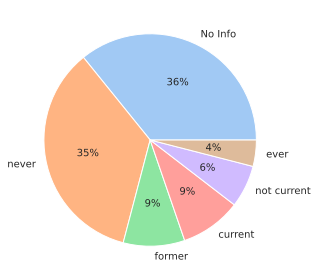

In [14]:
vc = pd.DataFrame(DF.smoking_history.value_counts(dropna=False))

colors = sns.color_palette('pastel') # [0:data.size]
plt.pie(vc['count'], labels=vc.index, colors=colors, autopct='%.0f%%')
plt.show()


In [15]:
# закодируем данное поле при помощи словаря
smoking_history_codes = {'No Info': -1, 'never': 0, 'former': 1, 'current': 2, 'not current': 3, 'ever': 4}

DF['smoking_history'].replace(smoking_history_codes, inplace=True)
# DF['smoking_history_bin'] = DF.smoking_history.map(smoking_history_codes, na_action='ignore')
DF

gender   age  hypertension  heart_disease  smoking_history    bmi   
0           1  80.0             0              1                0  25.19  \
1           1  54.0             0              0               -1  27.32   
2           0  28.0             0              0                0  27.32   
3           1  36.0             0              0                2  23.45   
4           0  76.0             1              1                2  20.14   
...       ...   ...           ...            ...              ...    ...   
99995       1  80.0             0              0               -1  27.32   
99996       1   2.0             0              0               -1  17.37   
99997       0  66.0             0              0                1  27.83   
99998       1  24.0             0              0                0  35.42   
99999       1  57.0             0              0                2  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140         0  
1              6.6                   80         0  
2              5.7                  158         0  
3              5.0                  155         0  
4              4.8                  155         0  
...            ...                  ...       ...  
99995          6.2                   90         0  
99996          6.5                  100         0  
99997          5.7                  155         0  
99998          4.0                  100         0  
99999          6.6                   90         0  

[99982 rows x 9 columns]

### Bmi

In [16]:
DF.bmi.value_counts(dropna=False)

bmi
27.32    25488
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
53.28        1
55.38        1
40.26        1
51.75        1
60.52        1
Name: count, Length: 4247, dtype: int64

### HbA1c_level

Подробнее тут: https://www.webmd.com/diabetes/guide/glycated-hemoglobin-test-hba1c

In [17]:
DF.HbA1c_level.value_counts(dropna=False)

HbA1c_level
6.6    8537
5.7    8412
6.5    8362
5.8    8321
6.0    8294
6.2    8267
6.1    8044
3.5    7659
4.8    7597
4.5    7584
4.0    7541
5.0    7469
8.8     661
8.2     661
9.0     654
7.5     643
6.8     642
7.0     634
Name: count, dtype: int64

### Blood_glucose_level

In [18]:
DF.blood_glucose_level.value_counts(dropna=False)

blood_glucose_level
130    7794
159    7756
140    7730
160    7708
126    7700
145    7679
200    7599
155    7575
90     7110
80     7105
100    7025
158    7024
85     6900
280     729
300     674
240     636
260     635
220     603
Name: count, dtype: int64

### Проверим выбросы

In [19]:
df_overview_boxplot(DF)

0it [00:00, ?it/s]

### Описательная статистика

In [20]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99982 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99982 non-null  int64  
 1   age                  99982 non-null  float64
 2   hypertension         99982 non-null  int64  
 3   heart_disease        99982 non-null  int64  
 4   smoking_history      99982 non-null  int64  
 5   bmi                  99982 non-null  float64
 6   HbA1c_level          99982 non-null  float64
 7   blood_glucose_level  99982 non-null  int64  
 8   diabetes             99982 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 7.6 MB


In [21]:
DF.describe()

gender           age  hypertension  heart_disease   
count  99982.000000  99982.000000  99982.000000   99982.000000  \
mean       0.585625     41.888076      0.074863       0.039427   
std        0.492616     22.517206      0.263172       0.194610   
min        0.000000      0.080000      0.000000       0.000000   
25%        0.000000     24.000000      0.000000       0.000000   
50%        1.000000     43.000000      0.000000       0.000000   
75%        1.000000     60.000000      0.000000       0.000000   
max        1.000000     80.000000      1.000000       1.000000   

       smoking_history           bmi   HbA1c_level  blood_glucose_level   
count     99982.000000  99982.000000  99982.000000         99982.000000  \
mean          0.274479     27.320757      5.527529           138.057810   
std           1.402889      6.636853      1.070665            40.709469   
min          -1.000000     10.010000      3.500000            80.000000   
25%          -1.000000     23.630000      4.800000           100.000000   
50%           0.000000     27.320000      5.800000           140.000000   
75%           1.000000     29.580000      6.200000           159.000000   
max           4.000000     95.690000      9.000000           300.000000   

           diabetes  
count  99982.000000  
mean       0.085015  
std        0.278906  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [22]:
# сохраним датасет
DF.to_pickle('data/df_clean.pickle')

## Корреляция признаков

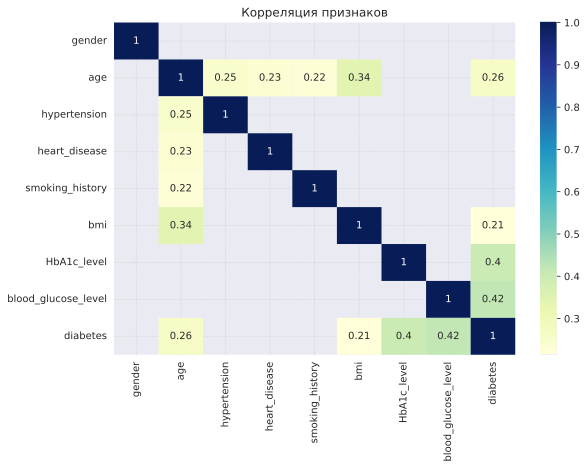

In [23]:
corr = DF.corr()
filt_corr = corr[np.abs(corr) >= 0.2]

plt.figure(figsize=(9, 6))
sns.heatmap(filt_corr, cmap="YlGnBu", annot=True)
plt.title("Корреляция признаков")
plt.show()

Уже видна линейная зависимость наличия диабета от __HbA1c_level__ и от __blood_glucose_level__

Наличие такой зависимости уже давно подтверждено научными исследованиям. Соответственно, данные поля должны стать "важными" фичами при обучении модели.

## Разделение датасета на тренировочную и валидационную часть

In [24]:
DF.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [25]:
FEATURES = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
TARGET = 'diabetes'

X_train, X_test, y_train, y_test = train_test_split(DF[FEATURES], DF[TARGET], test_size=0.3, stratify=DF[TARGET], random_state=42)

## Пайп-лайн

In [26]:
categ_feats = []
bin_feats = []
scaler_feats = FEATURES

TRANSFORMERS = []

for col in bin_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col))])))

for col in scaler_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('scaler', StandardScaler())])))

for col in categ_feats:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('ohe', OHEEncoder(key=col))])))


clf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'criterion': 'gini',
    'class_weight': 'balanced_subsample',
    # 'max_depth': 5,
    # 'min_samples_leaf': 1,
    # 'max_features': 'sqrt',
    # 'bootstrap': True
}

vc = y_train.value_counts()
scale_pos_weight = int(vc[0] / vc[1])

print(f"Соотношение классов '0' и '1': {scale_pos_weight}")

PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])
PIPELINE.steps.append(('clf', RandomForestClassifier(random_state=42, **clf_params)))
PIPELINE.verbose = True

# тренировка 
PIPELINE.fit(X_train, y_train)

# получим вероятности
y_test_pred_proba = PIPELINE.predict_proba(X_test)[:, 1]

Соотношение классов '0' и '1': 10
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.0s


## Метрики

Best Threshold=0.76 (idx=451) F-Score=0.804 Beta=1 Precision=0.998 Recall=0.674


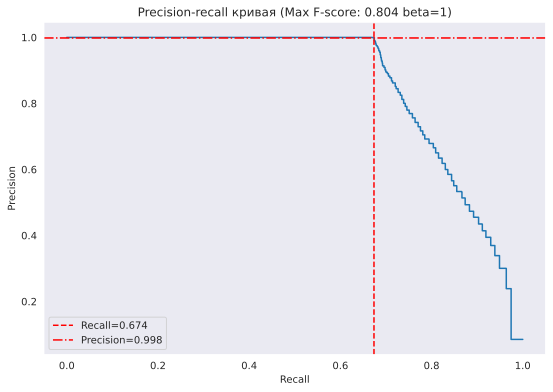

In [27]:
beta = 1
precision, recall, thresholds, fscore, ix = plot_precision_recall_curve(y_test, y_test_pred_proba, beta)

In [28]:
y_test_pred = y_test_pred_proba > thresholds[ix]

ROC-AUC score: 0.963


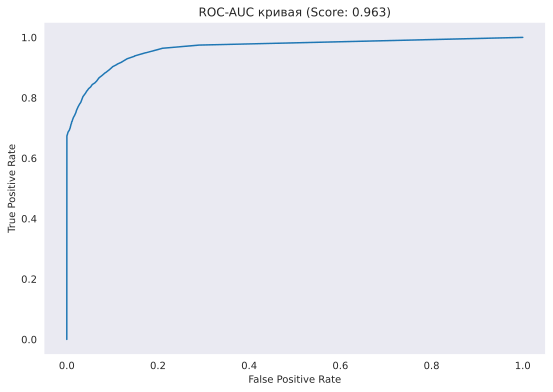

In [29]:
auc = plot_roc_auc_curve(y_test, y_test_pred_proba)

In [30]:
metrics = metric_calculation(y_test, y_test_pred, y_test_pred_proba)

Metrics:
Accuracy: 0.9720953492248708
F1: 0.8039353478566409
ROC-AUC: 0.963385766184776
Recall: 0.6729411764705883
Precision: 0.9982547993019197
Confusion matrix: TN=27442 FP=3 FN=834 TP=1716


## Важность признаков

In [31]:
feature_names = list(PIPELINE.named_steps['features'].get_feature_names_out())
feature_coeff = PIPELINE.named_steps['clf'].feature_importances_
feature_importance = pd.DataFrame({'feature_name': feature_names, 
                                   'feature_score': feature_coeff
                                   }).sort_values('feature_score', ascending=False).reset_index(drop=True)
feature_importance

feature_name  feature_score
0                  HbA1c_level__HbA1c_level       0.332135
1  blood_glucose_level__blood_glucose_level       0.269046
2                                  age__age       0.191658
3                                  bmi__bmi       0.129096
4          smoking_history__smoking_history       0.033786
5                hypertension__hypertension       0.022943
6              heart_disease__heart_disease       0.013671
7                            gender__gender       0.007664

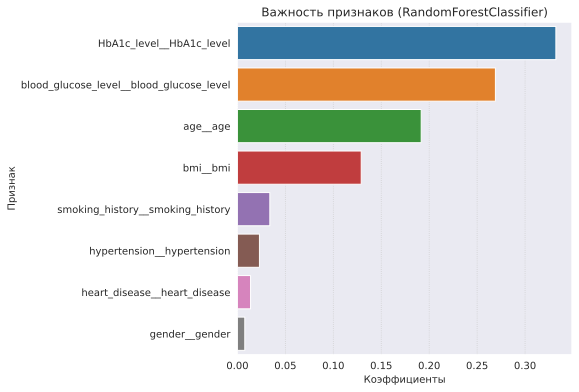

In [32]:
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance, y='feature_name', x='feature_score')
plt.ylabel("Признак")
plt.xlabel("Коэффициенты")
plt.title(f"Важность признаков ({PIPELINE.named_steps['clf'].__class__.__name__})")
plt.show()

## Вывод

1. Как и ожидалось, __HbA1c_level__, __blood_glucose_level__, __age__, __bmi__ являются очень важными признаками для предсказания наличия диабета

2. __smoking_history__ как-то влияет на целевую переменную, но у нас 36% данных неизвестны, возможно это отразилось на результате

3. __gender__ не важен

## Модель без gender

In [33]:
FEATURES = ['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
TARGET = 'diabetes'

X_train, X_test, y_train, y_test = train_test_split(DF[FEATURES], DF[TARGET], test_size=0.3, stratify=DF[TARGET], random_state=42)

In [34]:
TRANSFORMERS = []

for col in FEATURES:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), 
                                        ('scaler', StandardScaler())])))

clf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'criterion': 'gini',
    'class_weight': 'balanced_subsample',
    'max_depth': 6,
}

PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])
PIPELINE.steps.append(('clf', RandomForestClassifier(random_state=42, **clf_params)))
PIPELINE.verbose = True

# тренировка 
PIPELINE.fit(X_train, y_train)

# получим вероятности
y_test_pred_proba = PIPELINE.predict_proba(X_test)[:, 1]

[Pipeline] .......... (step 1 of 2) Processing features, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.4s


Best Threshold=0.8129066206213885 (idx=14477) F-Score=0.805 Beta=1 Precision=0.985 Recall=0.680


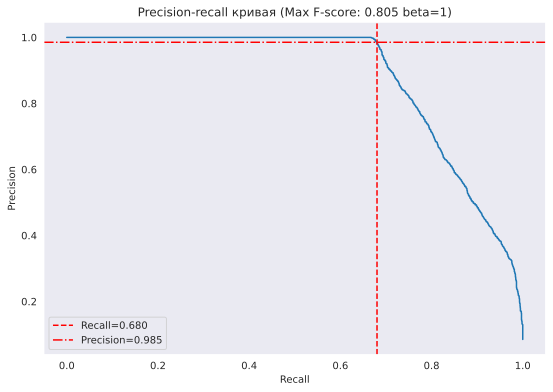

In [35]:
beta = 1
precision, recall, thresholds, fscore, ix = plot_precision_recall_curve(y_test, y_test_pred_proba, beta)

ROC-AUC score: 0.975


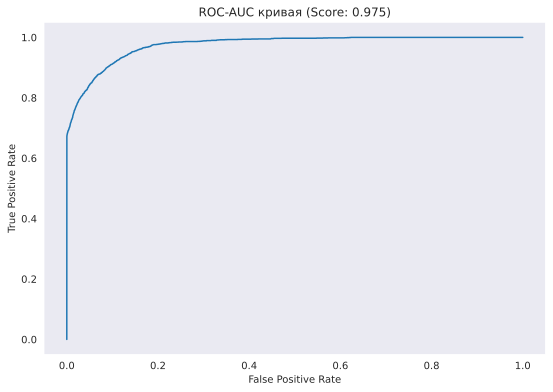

In [36]:
y_test_pred = y_test_pred_proba > thresholds[ix]

auc = plot_roc_auc_curve(y_test, y_test_pred_proba)

In [37]:
metrics = metric_calculation(y_test, y_test_pred, y_test_pred_proba)

Metrics:
Accuracy: 0.9719286547757959
F1: 0.8046403712296983
ROC-AUC: 0.9749213721560769
Recall: 0.68
Precision: 0.9852272727272727
Confusion matrix: TN=27419 FP=26 FN=816 TP=1734


In [38]:
feature_names = list(PIPELINE.named_steps['features'].get_feature_names_out())
feature_coeff = PIPELINE.named_steps['clf'].feature_importances_
feature_importance = pd.DataFrame({'feature_name': feature_names, 
                                   'feature_score': feature_coeff
                                   }).sort_values('feature_score', ascending=False).reset_index(drop=True)
feature_importance

feature_name  feature_score
0                  HbA1c_level__HbA1c_level       0.426125
1  blood_glucose_level__blood_glucose_level       0.299289
2                                  age__age       0.157739
3                                  bmi__bmi       0.065668
4                hypertension__hypertension       0.029272
5          smoking_history__smoking_history       0.012277
6              heart_disease__heart_disease       0.009628

In [39]:
PIPELINE.named_steps['clf'].get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## GridSearch

In [40]:
grid_params = {
    'clf__n_jobs': [-1],
    'clf__n_estimators': [100, 150],
    'clf__criterion': ['gini'],
    'clf__class_weight': ['balanced_subsample'],
    'clf__max_depth': [5, 10, 20, None],
}

grid = GridSearchCV(PIPELINE,  
                    param_grid=grid_params,       
                    scoring='roc_auc_ovr',
                    cv=6, 
                    n_jobs=-1, 
                    refit=False, 
                    verbose=1, 
                    return_train_score=True)

grid_search = grid.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_} Best score: {grid_search.best_score_}" )

Fitting 6 folds for each of 8 candidates, totalling 48 fits
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   9.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   9.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   9.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  10.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  10.2s
[Pipeline] ......

Best params: {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 150, 'clf__n_jobs': -1} Best score: 0.976485815445876

## Финальная сборка с лучшими параметрами

In [41]:
TRANSFORMERS = []

for col in FEATURES:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), 
                                        ('scaler', StandardScaler())])))

clf_params = {
    'n_jobs': -1,
    'n_estimators': 150,
    'criterion': 'gini',
    'class_weight': 'balanced_subsample',
    'max_depth': 10,
}

PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS)),
                     ('clf', RandomForestClassifier(random_state=42, **clf_params))], verbose=True)

# тренировка 
PIPELINE.fit(X_train, y_train)

# получим вероятности
y_test_pred_proba = PIPELINE.predict_proba(X_test)[:, 1]

[Pipeline] .......... (step 1 of 2) Processing features, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.5s


Best Threshold=0.853320012068987 (idx=22454) F-Score=0.809 Beta=1 Precision=0.978 Recall=0.689


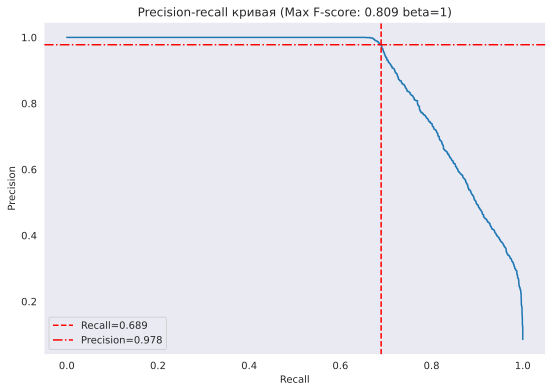

In [42]:
beta = 1
precision, recall, thresholds, fscore, ix = plot_precision_recall_curve(y_test, y_test_pred_proba, beta)

ROC-AUC score: 0.977


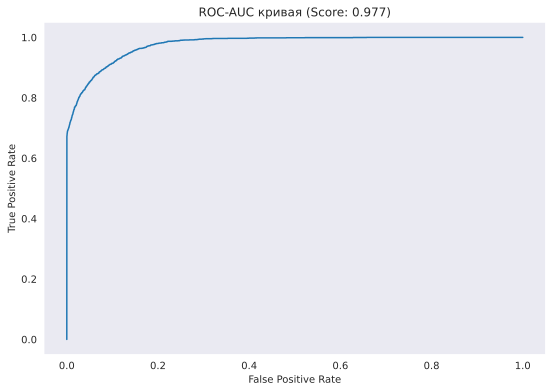

In [43]:
y_test_pred = y_test_pred_proba > thresholds[ix]

auc = plot_roc_auc_curve(y_test, y_test_pred_proba)

In [44]:
metrics = metric_calculation(y_test, y_test_pred, y_test_pred_proba)

Metrics:
Accuracy: 0.9722287047841307
F1: 0.8083735909822866
ROC-AUC: 0.9771253808865503
Recall: 0.6890196078431372
Precision: 0.9777406789092933
Confusion matrix: TN=27405 FP=40 FN=793 TP=1757


## Параметры финальной модели

In [45]:
PIPELINE.named_steps['clf'].get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
# запишем в PIPELINE значение выбранного нами уровня
PIPELINE.my_thresholds_level = thresholds[ix]
PIPELINE.my_thresholds_level

0.853320012068987

## Сохраним готовую модель

In [47]:
# dill format
with open("model/model.dill", "wb") as f:
    dill.dump(PIPELINE, f)

# pickle    
pd.to_pickle(PIPELINE, 'model/model.pickle')

# сохраним данные которые использовались для обучения и валидации модели
pd.to_pickle(X_train, 'data/X_train.pickle')
pd.to_pickle(y_train, 'data/y_train.pickle')
pd.to_pickle(X_test, 'data/X_test.pickle')
pd.to_pickle(y_test, 'data/y_test.pickle')
